In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━

In [2]:
!nvidia-smi

Tue Nov  5 14:13:55 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt
from evaluate import load as load_metric
import pandas as pd
from evaluate import load as load_metric

from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import nltk
from nltk.tokenize import sent_tokenize

from tqdm import tqdm
import torch

nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import torch

# Set device to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"

# Specify the T5 model checkpoint (e.g., t5-base, t5-small, or t5-large)
model_ckpt = "t5-base"  # Change this to 't5-small' or 't5-large' if needed

# Load T5 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [5]:
def generate_batch_sized_chunks(list_of_elements, batch_size):
    """Split the dataset into smaller batches that we can process simultaneously.
    Yield successive batch-sized chunks from list_of_elements."""
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]


In [6]:
from tqdm import tqdm

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                                 batch_size=16, device=device,
                                 column_text="article",
                                 column_summary="highlights"):
    # Create batches of articles and target summaries
    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        # Prepare input for T5 with the summarize prefix
        inputs = tokenizer(
            ["summarize: " + article for article in article_batch],
            max_length=512,  # Adjust max_length based on T5's capacity
            truncation=True,
            padding="max_length",
            return_tensors="pt"
        )

        # Generate summaries
        summaries = model.generate(
            input_ids=inputs["input_ids"].to(device),
            attention_mask=inputs["attention_mask"].to(device),
            length_penalty=0.8,
            num_beams=8,
            max_length=128
        )

        # Decode generated summaries
        decoded_summaries = [
            tokenizer.decode(s, skip_special_tokens=True, clean_up_tokenization_spaces=True)
            for s in summaries
        ]

        # If needed, process the decoded summaries (e.g., replace tokens)
        decoded_summaries = [d.replace("", " ") for d in decoded_summaries]

        # Add predictions and references to the metric
        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    # Compute and return the ROUGE scores
    score = metric.compute()
    return score


Load dataset

In [7]:
from datasets import load_dataset

# Load the Samsum dataset
dataset_samsum = load_dataset("samsum")

# Calculate and print the lengths of each dataset split
split_lengths = [len(dataset_samsum[split]) for split in dataset_samsum]
print(f"Split lengths: {split_lengths}")

# Print feature names in the training dataset
print(f"Features: {dataset_samsum['train'].column_names}")

# Print a specific dialogue and summary from the test dataset
print("\nDialogue:")
print(dataset_samsum["test"][1]["dialogue"])

print("\nSummary:")
print(dataset_samsum["test"][1]["summary"])


README.md:   0%|          | 0.00/7.04k [00:00<?, ?B/s]

samsum.py:   0%|          | 0.00/3.36k [00:00<?, ?B/s]

The repository for samsum contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/samsum.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


corpus.7z:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

Split lengths: [14732, 819, 818]
Features: ['id', 'dialogue', 'summary']

Dialogue:
Eric: MACHINE!
Rob: That's so gr8!
Eric: I know! And shows how Americans see Russian ;)
Rob: And it's really funny!
Eric: I know! I especially like the train part!
Rob: Hahaha! No one talks to the machine like that!
Eric: Is this his only stand-up?
Rob: Idk. I'll check.
Eric: Sure.
Rob: Turns out no! There are some of his stand-ups on youtube.
Eric: Gr8! I'll watch them now!
Rob: Me too!
Eric: MACHINE!
Rob: MACHINE!
Eric: TTYL?
Rob: Sure :)

Summary:
Eric and Rob are going to watch a stand-up on youtube.


Evaluating T5 on SAMSum

In [8]:
dataset_samsum['test'][0]['dialogue']

"Hannah: Hey, do you have Betty's number?\nAmanda: Lemme check\nHannah: <file_gif>\nAmanda: Sorry, can't find it.\nAmanda: Ask Larry\nAmanda: He called her last time we were at the park together\nHannah: I don't know him well\nHannah: <file_gif>\nAmanda: Don't be shy, he's very nice\nHannah: If you say so..\nHannah: I'd rather you texted him\nAmanda: Just text him 🙂\nHannah: Urgh.. Alright\nHannah: Bye\nAmanda: Bye bye"

In [9]:
pipe = pipeline('summarization', model = model_ckpt )

pipe_out = pipe(dataset_samsum['test'][0]['dialogue'] )

print(pipe_out)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your max_length is set to 200, but your input_length is only 133. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=66)


[{'summary_text': "file_gif> Amanda: Sorry, can't find it . Amanda: Ask Larry Amanda: he called her last time we were at the park together ."}]


In [10]:
print(pipe_out[0]['summary_text'].replace(" .<n>", ".\n"))

file_gif> Amanda: Sorry, can't find it . Amanda: Ask Larry Amanda: he called her last time we were at the park together .


In [11]:
from evaluate import load as load_metric

# Load the ROUGE metric
rouge_metric = load_metric('rouge')

# Calculate metrics on the test dataset using the T5 model
score = calculate_metric_on_test_ds(
    dataset=dataset_samsum['test'],  # Use the test split
    metric=rouge_metric,
    model=model_t5,                  # Change to the T5 model
    tokenizer=tokenizer,             # Use the T5 tokenizer
    column_text='dialogue',          # Input column name
    column_summary='summary',         # Target summary column name
    batch_size=8                      # Adjust batch size if needed
)

# Print the ROUGE scores
print("ROUGE scores:", score)

100%|██████████| 103/103 [12:02<00:00,  7.02s/it]


ROUGE scores: {'rouge1': 0.019174542746686684, 'rouge2': 0.0003161858231290872, 'rougeL': 0.018903028546956524, 'rougeLsum': 0.018819484444673927}


In [12]:
import pandas as pd

# Assuming `score` is a dictionary with ROUGE values obtained from calculate_metric_on_test_ds
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = {rn: score[rn] for rn in rouge_names}  # Direct access to scores

# Convert to DataFrame
rouge_df = pd.DataFrame(rouge_dict, index=['t5'])  # Update index to 't5' for T5 model

# Display DataFrame
print(rouge_df)


      rouge1    rouge2    rougeL  rougeLsum
t5  0.019175  0.000316  0.018903   0.018819


Histogram

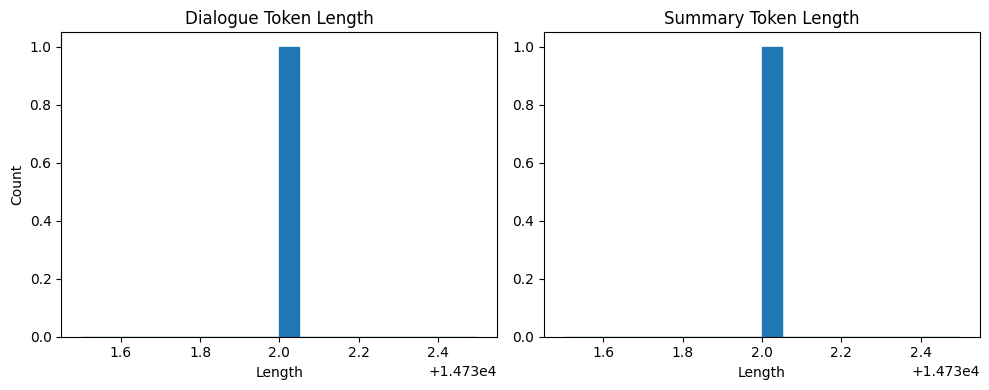

In [13]:
dialogue_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['dialogue']])

summary_token_len = len([tokenizer.encode(s) for s in dataset_samsum['train']['summary']])


fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].hist(dialogue_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")
axes[0].set_ylabel("Count")

axes[1].hist(summary_token_len, bins = 20, color = 'C0', edgecolor = 'C0' )
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()

In [14]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch['dialogue'] , max_length = 1024, truncation = True )

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch['summary'], max_length = 128, truncation = True )

    return {
        'input_ids' : input_encodings['input_ids'],
        'attention_mask': input_encodings['attention_mask'],
        'labels': target_encodings['input_ids']
    }

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features, batched = True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4126: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [15]:
from transformers import DataCollatorForSeq2Seq

# Create a data collator for T5
seq2seq_data_collator = DataCollatorForSeq2Seq(tokenizer, model=model_t5)


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
%cd /content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM

[Errno 2] No such file or directory: '/content/drive/MyDrive/005_BOKTIAR_AHMED_BAPPY/My_classes/FSDS_NOV_10_AM'
/content


In [18]:
from transformers import TrainingArguments, Trainer

trainer_args = TrainingArguments(
    output_dir='t5-samsum', num_train_epochs=1, warmup_steps=500,
    per_device_train_batch_size=1, per_device_eval_batch_size=1,
    weight_decay=0.01, logging_steps=10,
    evaluation_strategy='steps', eval_steps=500, save_steps=1e6,
    gradient_accumulation_steps=16
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [19]:
trainer = Trainer(model=model_t5, args=trainer_args,
                  tokenizer=tokenizer, data_collator=seq2seq_data_collator,
                  train_dataset=dataset_samsum_pt["train"],
                  eval_dataset=dataset_samsum_pt["validation"])

In [20]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss
500,1.658100,1.452666


TrainOutput(global_step=920, training_loss=1.7614311674366827, metrics={'train_runtime': 1862.5108, 'train_samples_per_second': 7.91, 'train_steps_per_second': 0.494, 'total_flos': 2606964191308800.0, 'train_loss': 1.7614311674366827, 'epoch': 0.9991854466467553})

In [21]:
score = calculate_metric_on_test_ds(
    dataset_samsum['test'], rouge_metric, trainer.model, tokenizer, batch_size = 2, column_text = 'dialogue', column_summary= 'summary'
)

rouge_dict = dict((rn, score[rn]) for rn in rouge_names)


pd.DataFrame(rouge_dict, index = [f't5'] )

100%|██████████| 410/410 [07:42<00:00,  1.13s/it]


,rouge1,rouge2,rougeL,rougeLsum
t5,0.034551,0.000474,0.033456,0.03346


<Figure size 1000x600 with 0 Axes>

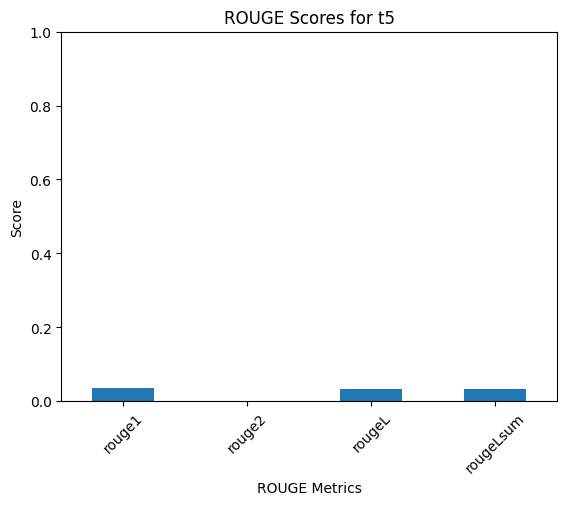

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming rouge_dict and 'pegasus' DataFrame creation is done
rouge_df = pd.DataFrame(rouge_dict, index=['t5'])

# Transpose the DataFrame for easier plotting
rouge_df = rouge_df.transpose()

# Plotting the values as a bar plot
plt.figure(figsize=(10, 6))
rouge_df.plot(kind='bar', legend=False)
plt.title('ROUGE Scores for t5')
plt.xlabel('ROUGE Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Assuming ROUGE scores range between 0 and 1
plt.xticks(rotation=45)
plt.show()


In [23]:
## Save model
model_t5.save_pretrained("t5-samsum-model")

In [24]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/spiece.model',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

Test

In [25]:
dataset_samsum = load_dataset("samsum")

In [26]:
tokenizer = AutoTokenizer.from_pretrained("tokenizer")

In [27]:
sample_text = dataset_samsum["test"][0]["dialogue"]

reference = dataset_samsum["test"][0]["summary"]

In [30]:
gen_kwargs = {"length_penalty": 0.8, "num_beams":8, "max_length": 128}

pipe = pipeline("summarization", model="t5-samsum-model",tokenizer=tokenizer)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [31]:
print("Dialogue:")
print(sample_text)


print("\nReference Summary:")
print(reference)


print("\nModel Summary:")
print(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

Dialogue:
Hannah: Hey, do you have Betty's number?
Amanda: Lemme check
Hannah: <file_gif>
Amanda: Sorry, can't find it.
Amanda: Ask Larry
Amanda: He called her last time we were at the park together
Hannah: I don't know him well
Hannah: <file_gif>
Amanda: Don't be shy, he's very nice
Hannah: If you say so..
Hannah: I'd rather you texted him
Amanda: Just text him 🙂
Hannah: Urgh.. Alright
Hannah: Bye
Amanda: Bye bye

Reference Summary:
Hannah needs Betty's number but Amanda doesn't have it. She needs to contact Larry.

Model Summary:
Larry called Betty last time they were at the park together. Hannah doesn't know him well. She'd rather she text him.


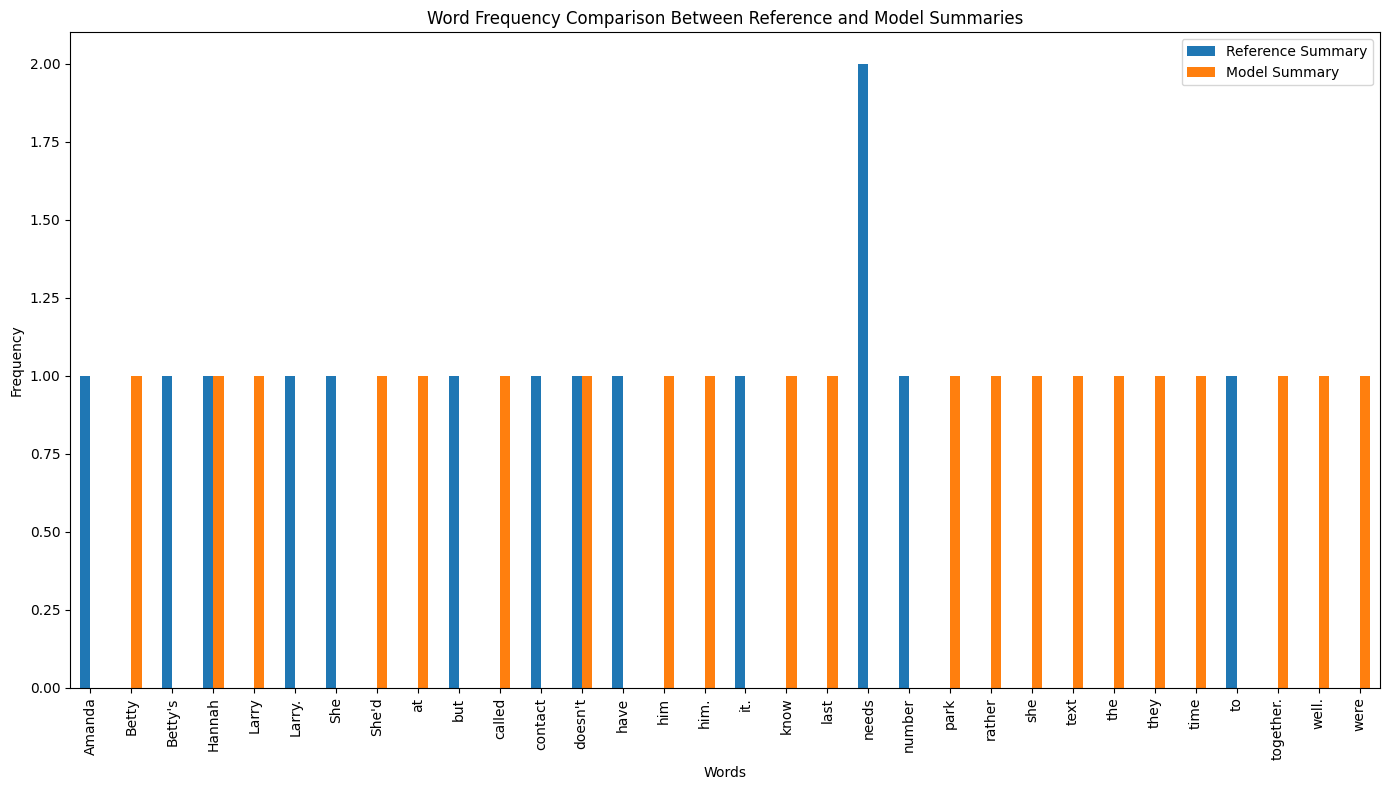

In [32]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt

# Calculate word frequencies for the reference and model summaries
reference_freq = Counter(reference.split())
model_freq = Counter(pipe(sample_text, **gen_kwargs)[0]["summary_text"].split())

# Create a set of all unique words from both reference and model frequencies
all_words = sorted(set(reference_freq.keys()).union(set(model_freq.keys())))

# Create the DataFrame with the corrected index
data = {
    'Reference': [reference_freq.get(word, 0) for word in all_words],
    'Model': [model_freq.get(word, 0) for word in all_words]
}
word_freq_df = pd.DataFrame(data, index=all_words)

# Plotting the word frequency comparison
word_freq_df.plot(kind='bar', figsize=(14, 8))
plt.title('Word Frequency Comparison Between Reference and Model Summaries')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.legend(['Reference Summary', 'Model Summary'])
plt.tight_layout()
plt.show()


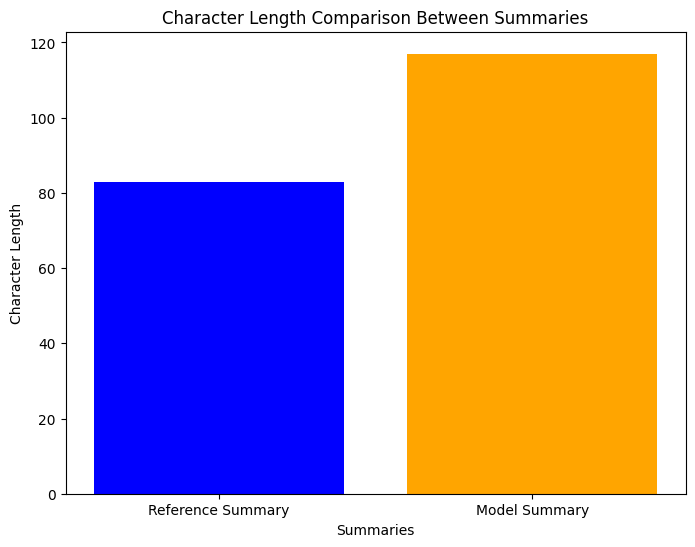

In [33]:

# Calculate the character lengths
reference_summary_length = len(reference)
model_summary_length = len(pipe(sample_text, **gen_kwargs)[0]["summary_text"])

# Data for plotting
summary_labels = ['Reference Summary', 'Model Summary']
summary_lengths = [reference_summary_length, model_summary_length]

# Plotting the character length comparison
plt.figure(figsize=(8, 6))
plt.bar(summary_labels, summary_lengths, color=['blue', 'orange'])
plt.title('Character Length Comparison Between Summaries')
plt.xlabel('Summaries')
plt.ylabel('Character Length')
plt.show()